In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from EnderClassifierModified import EnderClassifier as EnderFast
from EnderClassifierBoundedFast import EnderClassifier as EnderBounded
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score

In [135]:
def run_test(model, name, X_train, y_train, X_test, y_test):
    if len(np.unique(y_train)) != 2 or len(np.unique(y_test)) != 2:
        print(f"Skipping {name} as it is not a binary classification problem.")
        return
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    if y_pred.ndim > 1:
        y_pred = np.array([np.argmax(pred) for pred in y_pred])
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(name)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("Classification Report - Test:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    labels = ['Class 0', 'Class 1']
    print("Confusion Matrix:")
    print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
    print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
    print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [123]:
def find_best_n(ender_version, use_gradient, X_train, y_train, X_test, y_test, min_n=0, max_n=31):
    best_acc = 0
    best_n = 0
    best_acc_auc = 0
    best_acc_f1 = 0
    best_auc = 0
    best_n_auc = 0
    best_auc_acc = 0
    best_auc_f1 = 0
    best_f1 = 0
    best_n_f1 = 0
    best_f1_auc = 0
    best_f1_acc = 0
    for n_rules in range(min_n, max_n):
        ender = ender_version(verbose=False, n_rules=n_rules, use_gradient=use_gradient)
        ender.fit(X_train, y_train)
        y_pred = ender.predict(X_test)
        y_pred = np.array(y_pred)
        y_pred = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        y_proba = ender.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        if acc > best_acc + 1e-6:
            best_acc = acc
            best_n = n_rules
            best_acc_auc = auc
            best_acc_f1 = f1
        if auc > best_auc + 1e-6:
            best_auc = auc
            best_auc_acc = acc
            best_n_auc = n_rules
            best_auc_f1 = f1
        if f1 > best_f1 + 1e-6:
            best_f1 = f1
            best_n_f1 = n_rules
            best_f1_auc = auc
            best_f1_acc = acc
    print(f"Best accuracy: {best_acc:.4f} with n_rules: {best_n}, AUC: {best_acc_auc:.4f}, F1: {best_acc_f1:.4f}")
    print(f"Best AUC: {best_auc:.4f} with n_rules: {best_n_auc}, Accuracy: {best_auc_acc:.4f}, F1: {best_auc_f1:.4f}")
    print(f"Best F1: {best_f1:.4f} with n_rules: {best_n_f1}, AUC: {best_f1_auc:.4f}, Accuracy: {best_f1_acc:.4f}")

In [28]:
from ucimlrepo import fetch_ucirepo 
  
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
heart_disease = fetch_ucirepo(id=45)
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
liver_disorders = fetch_ucirepo(id=60) 
ilpd_indian_liver_patient_dataset = fetch_ucirepo(id=225)

c:\Users\iwama\Desktop\Osobiste\MSc\mscenv\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [86]:
diabetes_X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
diabetes_y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

heart_disease_X = heart_disease.data.features
heart_disease_y = heart_disease.data.targets

breast_cancer_X = breast_cancer_wisconsin_diagnostic.data.features
breast_cancer_y = breast_cancer_wisconsin_diagnostic.data.targets

liver_disorders_X = liver_disorders.data.features
liver_disorders_y = liver_disorders.data.targets

ilpd_X = ilpd_indian_liver_patient_dataset.data.features
ilpd_y = ilpd_indian_liver_patient_dataset.data.targets

In [58]:
print("Diabetes dataset shape:", diabetes_X.shape)
print("Heart Disease dataset shape:", heart_disease_X.shape)
print("Breast Cancer dataset shape:", breast_cancer_X.shape)
print("Liver Disorders dataset shape:", liver_disorders_X.shape)
print("ILPD dataset shape:", ilpd_X.shape)

Diabetes dataset shape: (101766, 47)
Heart Disease dataset shape: (303, 13)
Breast Cancer dataset shape: (569, 30)
Liver Disorders dataset shape: (345, 5)
ILPD dataset shape: (583, 10)


In [59]:
print("Diabetes dataset missing values:", diabetes_X.isnull().sum().sum())
print("Heart Disease dataset missing values:", heart_disease_X.isnull().sum().sum())
print("Breast Cancer dataset missing values:", breast_cancer_X.isnull().sum().sum())
print("Liver Disorders dataset missing values:", liver_disorders_X.isnull().sum().sum())
print("ILPD dataset missing values:", ilpd_X.isnull().sum().sum())

Diabetes dataset missing values: 374017
Heart Disease dataset missing values: 6
Breast Cancer dataset missing values: 0
Liver Disorders dataset missing values: 0
ILPD dataset missing values: 4


In [60]:
# print the number of classes in each dataset
print("Diabetes dataset classes:", np.unique(diabetes_y))
print("Heart Disease dataset classes:", np.unique(heart_disease_y))
print("Breast Cancer dataset classes:", np.unique(breast_cancer_y))
print("Liver Disorders dataset classes:", np.unique(liver_disorders_y))
print("ILPD dataset classes:", np.unique(ilpd_y))

Diabetes dataset classes: ['<30' '>30' 'NO']
Heart Disease dataset classes: [0 1 2 3 4]
Breast Cancer dataset classes: ['B' 'M']
Liver Disorders dataset classes: [ 0.   0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  12.  15.
 16.  20. ]
ILPD dataset classes: [1 2]


### Classification on Breast Cancer:

In [87]:
# the target variable is "B" or "M", but we need to convert it to 0 and 1
breast_cancer_y = np.where(breast_cancer_y == 'M', 1, 0).reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(breast_cancer_X, breast_cancer_y, test_size=0.25, random_state=42)

XGBoost
Accuracy: 0.9650
ROC AUC: 0.9925
F1 Score: 0.9533
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        89
           1       0.96      0.94      0.95        54

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             87                  2                     # True Negative (TN), False Positive (FP)
Class 1             3                   51                    # False Negative (FN), True Positive (TP)


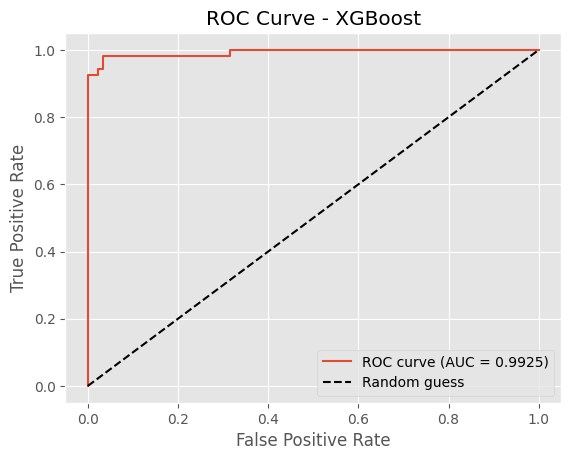

In [136]:
xgb_model = xgb.XGBClassifier()
run_test(xgb_model, "XGBoost", X_train, y_train, X_test, y_test)

In [124]:
find_best_n(EnderFast, use_gradient=True, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, max_n=51, min_n=0)

Best accuracy: 0.9510 with n_rules: 2, AUC: 0.9815, F1: 0.9346
Best AUC: 0.9940 with n_rules: 23, Accuracy: 0.9510, F1: 0.9369
Best F1: 0.9369 with n_rules: 8, AUC: 0.9925, Accuracy: 0.9510


Ender Fast Gradient
Accuracy: 0.9510
ROC AUC: 0.9940
F1 Score: 0.9369
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        89
           1       0.91      0.96      0.94        54

    accuracy                           0.95       143
   macro avg       0.94      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             84                  5                     # True Negative (TN), False Positive (FP)
Class 1             2                   52                    # False Negative (FN), True Positive (TP)


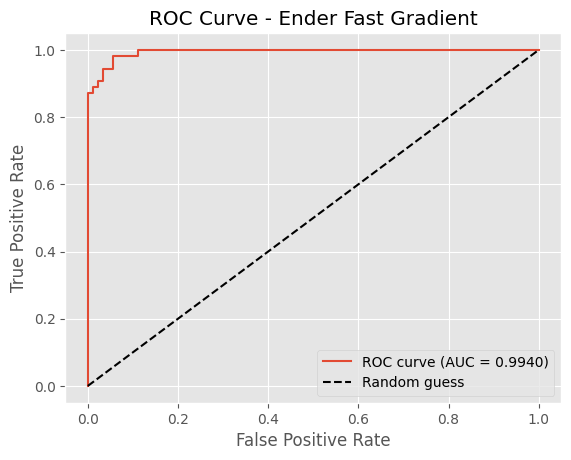

In [137]:
ender_fast_gradient = EnderFast(verbose=False, n_rules=23, use_gradient=True)
run_test(ender_fast_gradient, "Ender Fast Gradient", X_train, y_train, X_test, y_test)

In [129]:
find_best_n(EnderFast, use_gradient=False, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, min_n=0, max_n=51)

Best accuracy: 0.9790 with n_rules: 15, AUC: 0.9941, F1: 0.9725
Best AUC: 0.9943 with n_rules: 16, Accuracy: 0.9790, F1: 0.9725
Best F1: 0.9725 with n_rules: 15, AUC: 0.9941, Accuracy: 0.9790


Ender Fast No Gradient
Accuracy: 0.9790
ROC AUC: 0.9943
F1 Score: 0.9725
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        89
           1       0.96      0.98      0.97        54

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             87                  2                     # True Negative (TN), False Positive (FP)
Class 1             1                   53                    # False Negative (FN), True Positive (TP)


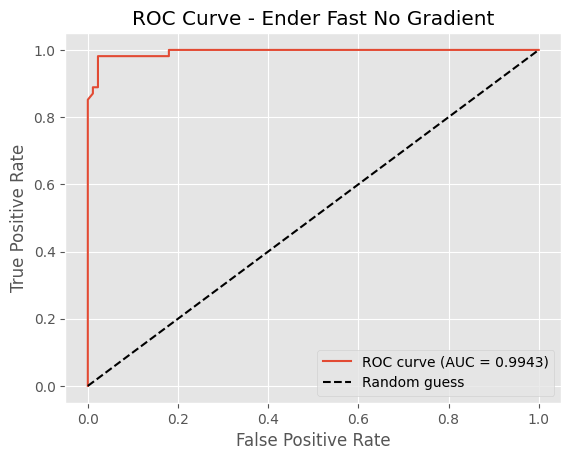

In [138]:
ender_fast_nograd = EnderFast(verbose=False, n_rules=16, use_gradient=False)
run_test(ender_fast_nograd, "Ender Fast No Gradient", X_train, y_train, X_test, y_test)

In [131]:
find_best_n(EnderBounded, use_gradient=False, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, max_n=51, min_n=0)

Best accuracy: 0.9720 with n_rules: 8, AUC: 0.9929, F1: 0.9630
Best AUC: 0.9952 with n_rules: 32, Accuracy: 0.9650, F1: 0.9541
Best F1: 0.9630 with n_rules: 8, AUC: 0.9929, Accuracy: 0.9720


Ender Bounded No Gradient
Accuracy: 0.9720
ROC AUC: 0.9929
F1 Score: 0.9630
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        89
           1       0.96      0.96      0.96        54

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             87                  2                     # True Negative (TN), False Positive (FP)
Class 1             2                   52                    # False Negative (FN), True Positive (TP)


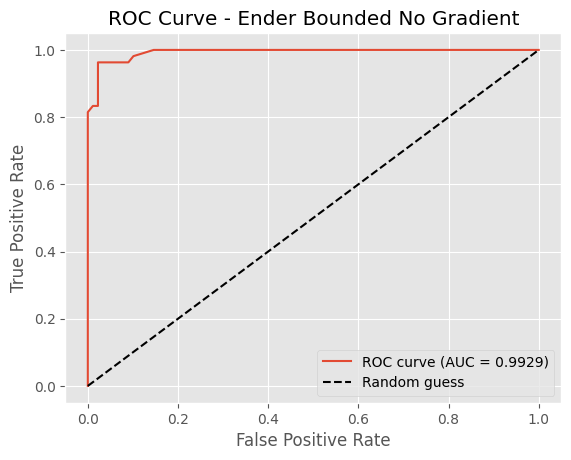

In [141]:
run_test(EnderBounded(verbose=False, n_rules=8, use_gradient=False), "Ender Bounded No Gradient", X_train, y_train, X_test, y_test)

In [143]:
find_best_n(EnderBounded, use_gradient=True, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, max_n=51, min_n=0)

Best accuracy: 0.9720 with n_rules: 31, AUC: 0.9967, F1: 0.9636
Best AUC: 0.9969 with n_rules: 19, Accuracy: 0.9580, F1: 0.9455
Best F1: 0.9636 with n_rules: 31, AUC: 0.9967, Accuracy: 0.9720


Ender Bounded with Gradient
Accuracy: 0.9720
ROC AUC: 0.9967
F1 Score: 0.9636
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        89
           1       0.95      0.98      0.96        54

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             86                  3                     # True Negative (TN), False Positive (FP)
Class 1             1                   53                    # False Negative (FN), True Positive (TP)


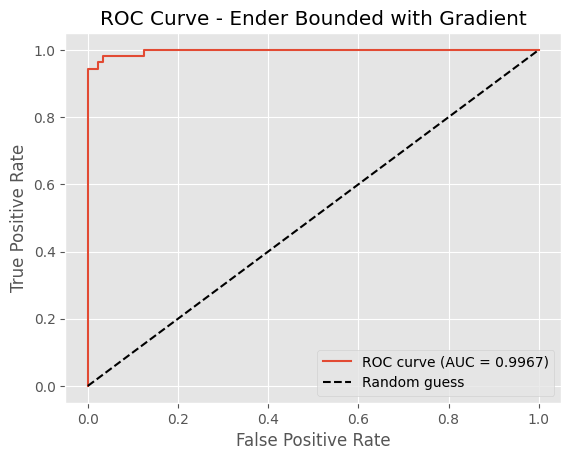

In [144]:
run_test(EnderBounded(verbose=False, n_rules=31, use_gradient=True), "Ender Bounded with Gradient", X_train, y_train, X_test, y_test)